# How meaningful are Gaussian ODE filter uncertainties?

We investigate whether the uncertaintes returned by Gaussian ODE Filters are meaningful as actual error estimates---or even better?


In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../../probnum.mplstyle')

In [2]:
import numpy as np

import probnum.diffeq as diffeq
from probnum.diffeq import IVP
from probnum.diffeq import lotkavolterra
from probnum import random_variables as rvs
from probnum.diffeq import logistic, probsolve_ivp


np.random.seed(123)

We start with the Lotka-Volterra equations.

In [3]:
initdist = rvs.Constant(np.array([20.0, 20.0]))

lv = lotkavolterra([0.0, 20.0], initdist)

The EK0 ODE filter is quite fast and flexible, but does not yield accurate uncertainty estimates. We see below that the uncertainty increases monotonously, independent on the actual peaks and valleys of the ODE solution.

It is not surprising that the EK0 solution is agnostic of the trajectory. In fact, the covariance of the EK0 filter is independent of the data and as such, we cannot expect it to return useful uncertainty.

In [4]:
sol = probsolve_ivp(lv, method="eks0", which_prior="ibm1", step=0.1)

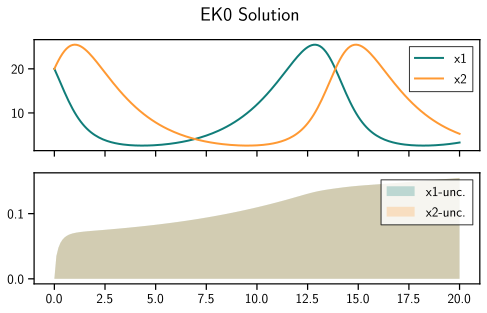

In [5]:
means, stds = sol.y.mean, sol.y.std

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(sol.t, means[:, 0], label="x1")
ax1.plot(sol.t, means[:, 1], label="x2")
ax1.legend()
ax2.fill_between(sol.t, stds[:, 0], alpha=0.25, label="x1-unc.")
ax2.fill_between(sol.t, stds[:, 1], alpha=0.25, label="x2-unc.")
ax2.legend()
fig.suptitle("EK0 Solution")
plt.show()

Notice that the uncertainties are aware of the peaks and valleys. They even know whether the peak is flat (rhs of blue, lhs of orange; smaller ones of the blue peaks) or steep. On top of that, they increase over time.

For both we can also sample from the solution. Let us compute a low-res solution (so the samples actually look different from each other).

Beware, because large numbers of samples can take a long time to compute.

In [6]:
sol = probsolve_ivp(lv, method="eks0", which_prior="ibm1", step=0.5)

In [7]:
num_samples = 10
locations = np.arange(0., 22.5, 0.1)
unit_samples = np.array([np.random.randn(len(locations), len(sol.kalman_posterior.state_rvs[0].mean)) for _ in range(num_samples)])

samples = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples])
solution = sol(locations)
means = solution.mean
stds = solution.std

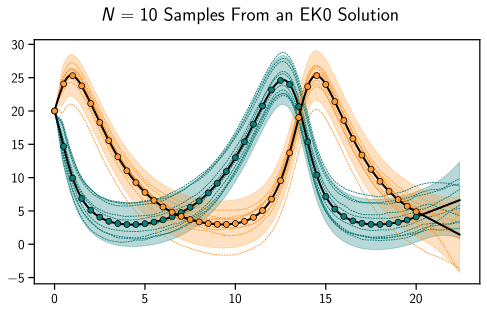

In [8]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True)
for sample in samples:
    ax1.plot(locations, sample[:, 0], ":", color="C0", linewidth="1", alpha=1)
    ax1.plot(locations, sample[:, 1], ":", color="C1", linewidth="1", alpha=1)
ax1.plot(locations, means[:, 0], label="x1", color="k")
ax1.plot(locations, means[:, 1], label="x2", color="k")
ax1.fill_between(
    locations,
    means[:, 0] - 2 * stds[:, 0],
    means[:, 0] + 2 * stds[:, 0],
    color="C0",
    alpha=0.3,
)
ax1.fill_between(
    locations,
    means[:, 1] - 2 * stds[:, 1],
    means[:, 1] + 2 * stds[:, 1],
    color="C1",
    alpha=0.3,
)

ax1.plot(sol.t, sol.y.mean, "o")
fig.suptitle(f"$N={num_samples}$ Samples From an EK0 Solution")

plt.show()

In [9]:

def grand_circle_unitsphere(d, num_steps):
    """Traverse the surface of a d-sphere along a (d-1)-dimensional subspace in N steps.
    
    This can be used to "make a sample from a GP move around in the sample space".
    In this case, d is the number of time-grid points, and num_steps is the number 
    of frames that shall be shown in the animation.
    
    
    Parameters
    ----------
    d:
        Dimension of the sphere.
    num_steps:
        Number of steps to be taken.
    
    Returns
    -------
    N steps that traverse the sphere along a (d-1)-dimensional subspace.
    Shape (d, num_steps).
    """

    x = np.random.randn(d, 1)

    r = np.linalg.norm(x)
    x = x / r


    t = np.random.randn(d, 1)
    t = t - (t.T @ x) * x

    t = t / np.linalg.norm(t)


    s = np.linspace(0, 2.*np.pi, num_steps+1)[:-1]
    assert len(s) == num_steps
    out = np.array([ r * exp_map(x, t*l) for l in s]) 
    return out[:, :, 0].T


def exp_map(mu, E):
    """Compute the exponential map on a manifold.
    
    In other words, move from point mu with velocity E.
    """
    D = E.shape[0]
    theta = np.linalg.norm(E)
    x = mu * np.cos(theta)
    if theta == 0.:
        return mu
    y = E * np.tile(np.sin(theta) / theta, (D, 1)) 
    M = x + y
    if np.any(np.abs(theta) < 1e-7):
        for a in np.where(np.abs(theta) <= 1e-7):
            M[:, a] = mu

    return M

In [10]:
num_samples = 15
locations = np.arange(0., 25.1, 0.1)
space_dim = len(sol.kalman_posterior.state_rvs[-1].mean)

print(space_dim, len(locations), num_samples)

4 251 15


In [11]:
# unit_samples = np.array([grand_circle_unitsphere(d=len(locations), num_steps=20) for _ in range(4)]).T
unit_samples1 = grand_circle_unitsphere(d=len(locations)*space_dim, num_steps=num_samples).reshape((space_dim, len(locations), num_samples)).T
unit_samples2 = grand_circle_unitsphere(d=len(locations)*space_dim, num_steps=num_samples).reshape((space_dim, len(locations), num_samples)).T
unit_samples3 = grand_circle_unitsphere(d=len(locations)*space_dim, num_steps=num_samples).reshape((space_dim, len(locations), num_samples)).T

print(unit_samples.shape)

(10, 225, 4)


In [12]:
# unit_samples = np.array([np.random.randn(len(locations), len(sol.kalman_posterior.state_rvs[0].mean)) for _ in range(num_samples)])
# print(unit_samples.shape)

In [13]:

samples1 = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples1])
samples2 = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples2])
samples3 = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples3])
solution = sol(locations)
means = solution.mean
stds = solution.std

In [14]:
%matplotlib
from celluloid import Camera


Using matplotlib backend: TkAgg


In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10, 4), constrained_layout=True)

camera = Camera(fig)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_xlim((np.amin(locations), np.amax(locations)))
ax1.set_ylim((-10, 40))
ax2.set_xlim((-10, 40))
ax2.set_ylim((-10, 40))


for i, (sample1, sample2, sample3) in enumerate(zip(samples1, samples2, samples3)):
    ax1.plot(locations, means[:, 0], label="x1", color="k")
    ax1.plot(locations, means[:, 1], label="x2", color="k")
    for l in np.linspace(0, 3, 20):
        ax1.fill_between(
            locations,
            means[:, 0] - l * stds[:, 0],
            means[:, 0] + l * stds[:, 0],
            color="forestgreen",
            alpha=0.04,
        )
        ax1.fill_between(
            locations,
            means[:, 1] - l * stds[:, 1],
            means[:, 1] + l * stds[:, 1],
            color="darksalmon",
            alpha=0.04,
            label="+- 1 std"
        )
    # ax1.plot(sol.t, sol.y.mean, "o")
    # fig.suptitle(f"$N={num_samples}$ Samples From an EK0 Solution (+/-1 stdev)")
    ax1.plot(locations, sample1[:, 0], ":", color="forestgreen", linewidth=1.5, alpha=1)
    ax1.plot(locations, sample1[:, 1], ":", color="darksalmon", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample2[:, 0], ":", color="forestgreen", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample2[:, 1], ":", color="darksalmon", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample3[:, 0], ":", color="forestgreen", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample3[:, 1], ":", color="darksalmon", linewidth=1.5, alpha=1)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Population")
    ax1.axvline(20., color="black", linewidth=1.5, linestyle="dotted" )

    
    ax2.plot(sample1[:, 0], sample1[:, 1], ":", color="darkslategray", linewidth=4., alpha=0.25)
    ax2.plot(sample2[:, 0], sample2[:, 1], ":", color="darkslategray", linewidth=4., alpha=0.25)
    ax2.plot(sample3[:, 0], sample3[:, 1], ":", color="darkslategray", linewidth=4., alpha=0.25)
    ax2.plot(means[:, 0], means[:, 1], "-", color="black")
    ax2.set_xlabel("Predators")
    ax2.set_ylabel("Prey")
    camera.snap()

animation = camera.animate()
animation.save('animation.gif')

In [16]:
import scipy.linalg

In [17]:
def k(t1, t2, lengthscale=0.5):
    return np.exp(-np.sin(np.abs(t1-t2))**2/(2*lengthscale))

In [18]:
num_samples = 25
T = np.linspace(0, 2*np.pi, num_samples)
K = k(T[:, None], T[None, :])
K = (K + K.T) / 2
sample = np.random.multivariate_normal(np.zeros(len(T)), K, size=(len(locations) * space_dim)).reshape((-1, space_dim, num_samples)).T
unit_samples = np.transpose(sample, axes=(0, 2, 1))
sample = np.transpose(sample, axes=(0, 2, 1))
print(sample.shape)
print(sample[:, 0, 0])

(25, 251, 4)
[ 0.91388428  1.0556675   1.17332993  1.04282742  0.5623677   0.08639007
 -0.21824852 -0.54910232 -0.58443886 -0.00619919  0.58423359  0.79189579
  0.91388431  1.0556675   1.17332993  1.04282738  0.56236774  0.08639005
 -0.21824852 -0.54910231 -0.58443885 -0.00619917  0.5842336   0.79189582
  0.91388426]


In [19]:
sample = np.random.multivariate_normal(np.zeros(len(T)), K, size=(len(locations) * space_dim)).reshape((-1, space_dim, num_samples)).T
unit_samples1 = np.transpose(sample, axes=(0, 2, 1))

sample = np.random.multivariate_normal(np.zeros(len(T)), K, size=(len(locations) * space_dim)).reshape((-1, space_dim, num_samples)).T
unit_samples2 = np.transpose(sample, axes=(0, 2, 1))

sample = np.random.multivariate_normal(np.zeros(len(T)), K, size=(len(locations) * space_dim)).reshape((-1, space_dim, num_samples)).T
unit_samples3 = np.transpose(sample, axes=(0, 2, 1))
sample = unit_samples1

In [20]:
fig = plt.figure(dpi=150)
cam = Camera(fig)
for smp in sample:
    plt.title("White(ish) starting samples")
    plt.plot(np.arange(len(locations)), smp[:, 0], marker="o", color="darksalmon", linestyle="None")
    cam.snap()
anim = cam.animate()
anim.save("white_starting_samples.gif")

In [21]:
fig = plt.figure(dpi=150)
cam2 = Camera(fig)
x = np.linspace(-4, 4)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
for smp in sample.T:
    plt.title("Histogram of white(ish) starting samples")
    plt.hist(smp[:, 0], bins=50, density=True, color="darksalmon")
    plt.plot(x, y, color="black")

    cam2.snap()
    
anim2 = cam2.animate()
anim2.save("hist_white_starting_samples.gif")

In [22]:
samples1 = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples1])
samples2 = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples2])
samples3 = np.array([sol.sample(t=locations, unit_samples=usamp) for usamp in unit_samples3])


In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10, 4), constrained_layout=True)

camera = Camera(fig)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_xlim((np.amin(locations), np.amax(locations)))
ax1.set_ylim((-10, 40))
ax2.set_xlim((-10, 40))
ax2.set_ylim((-10, 40))


for i, (sample1, sample2, sample3) in enumerate(zip(samples1, samples2, samples3)):
    ax1.plot(locations, means[:, 0], label="x1", color="k")
    ax1.plot(locations, means[:, 1], label="x2", color="k")
    for l in np.linspace(0, 3, 20):
        ax1.fill_between(
            locations,
            means[:, 0] - l * stds[:, 0],
            means[:, 0] + l * stds[:, 0],
            color="forestgreen",
            alpha=0.04,
        )
        ax1.fill_between(
            locations,
            means[:, 1] - l * stds[:, 1],
            means[:, 1] + l * stds[:, 1],
            color="darksalmon",
            alpha=0.04,
            label="+- 1 std"
        )
    # ax1.plot(sol.t, sol.y.mean, "o")
    # fig.suptitle(f"$N={num_samples}$ Samples From an EK0 Solution (+/-1 stdev)")
    ax1.plot(locations, sample1[:, 0], ":", color="forestgreen", linewidth=1.5, alpha=1)
    ax1.plot(locations, sample1[:, 1], ":", color="darksalmon", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample2[:, 0], ":", color="forestgreen", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample2[:, 1], ":", color="darksalmon", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample3[:, 0], ":", color="forestgreen", linewidth=1.5, alpha=1)
    # ax1.plot(locations, sample3[:, 1], ":", color="darksalmon", linewidth=1.5, alpha=1)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Population")
    ax1.axvline(20., color="black", linewidth=1.5, linestyle="dotted" )

    
    ax2.plot(sample1[:, 0], sample1[:, 1], ":", color="darkslategray", linewidth=4., alpha=0.25)
    ax2.plot(sample2[:, 0], sample2[:, 1], ":", color="darkslategray", linewidth=4., alpha=0.25)
    ax2.plot(sample3[:, 0], sample3[:, 1], ":", color="darkslategray", linewidth=4., alpha=0.25)
    ax2.plot(means[:, 0], means[:, 1], "-", color="black")
    ax2.set_xlabel("Predators")
    ax2.set_ylabel("Prey")
    camera.snap()

animation3 = camera.animate()
animation3.save("gp_animation_samples.gif")

KeyboardInterrupt: 